<a href="https://colab.research.google.com/github/vasilijeIT23/PPPO_Age_Gender_Emotion_Detection/blob/main/models_performance_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEMONSTRATION OF PERFORMANCE OF ALL MODELS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from PIL import Image
import math
import shutil
import random
import csv

All methods needed for data preprocessing and model training. Methods are explained below, since every method is commented out.

In [ ]:
def extract_faces_from_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the pre-trained face detection classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Loop through all image files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Read an image
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Save each detected face as a new image in the output folder
            for i, (x, y, w, h) in enumerate(faces):
                face = img[y:y+h, x:x+w]
                output_path = os.path.join(output_folder, f'{filename}_face_{i}.jpg')
                cv2.imwrite(output_path, face)

def preprocess_age(img):
    # Preprocessing for Model 1 (assuming input size is 200x200)
    img = cv2.resize(img, (200, 200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = img.reshape((1, 200, 200, 1))  # Assuming channels-last format
    return img

def preprocess_gender(img):
    # Preprocessing for Model 2 (assuming input size is 100x100)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = img.reshape((1, 100, 100, 1))  # Assuming channels-last format
    return img

def preprocess_emotion(img):
    # Preprocessing for Model 3 (assuming input size is 48x48)
    img = cv2.resize(img, (48, 48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = img.reshape((1, 48, 48, 1))  # Assuming channels-last format
    return img

def prepare_and_predict_random_faces(input_folder, age_model, gender_model, emotion_model, num = 5):
    # List all files in the input folder
    face_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Randomly select five images
    selected_files = random.sample(face_files, min(num, len(face_files)))

    # Loop through the selected images
    for filename in selected_files:
        # Read the image
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)

        # Display the original image
        display_image(img)

        # Preprocess the image for each model
        preprocessed_img_age = preprocess_age(img.copy())
        preprocessed_img_gender = preprocess_gender(img.copy())
        preprocessed_img_emotion = preprocess_emotion(img.copy())

        # Make predictions using each model
        predictions_age_model = age_model.predict(preprocessed_img_age)

        predictions_gender_model = gender_model.predict(preprocessed_img_gender)

        predictions_emotion_model = emotion_model.predict(preprocessed_img_emotion)

        labels_age_model = ['1-8', '9-19', '20-31', '32-60', '61-110']
        labels_gender_model = ['male', 'female']
        labels_emotion_model = ['happy', 'anger', 'contempt', 'disgust', 'fear', 'sadness', 'surprise']

        display_predictions(predictions_age_model, labels_age_model, "Age Model")
        display_predictions(predictions_gender_model, labels_gender_model, "Gender Model")
        display_predictions(predictions_emotion_model, labels_emotion_model, "Emotions Model")

def display_image(img):
    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def display_predictions(predictions, labels, model_name):
    # Display predictions with labels for a given model
    print(f"Predictions for {model_name}:")
    for i, (prob, label) in enumerate(zip(predictions[0], labels)):
        print(f"{label}: {prob:.2%}")
    print()


Loading the models

In [ ]:
age_model = load_model('/content/drive/MyDrive/output_logs/age_detection_model/age_model_checkpoint_new.h5')
emotion_model = load_model('/content/drive/MyDrive/output_logs/emotion_detection_folder/emotion_model.h5')
gender_model = load_model('/content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5')

Since dataset i have to use for model evaluation is not compatible with data i used for model creation i need first to locate faces extract them and preprocess extracted faces to be usable for each model. For face recognition and extraction im using pretrained model from cv2 library.

In [ ]:
val_images_folder = '/content/drive/MyDrive/val_data'
cropped_faces_folder = '/content/drive/MyDrive/val_data_cropped'

extract_faces_from_images(val_images_folder, cropped_faces_folder)

Finding 5 random images from evaluation dataset and making predictions. Since evaluation dataset doesnt have csv file with true values, some of predictions that arent intuitively visible, cant be proved to be right or wrong. As we can se gender model is performing the best and almost every prediction is right. As for age model it performs fairly good since almost all images from evaluation dataset are approximately from the same age range(31 - 60) and model usualy predicts that age range with arount 40% confidence. Emotion model is performing the worst as it predicts every emotion with around the same confidence. My explanation would be that i overtrained it on small dataset(around 1000 photos) i used, so the model got really good but only for that dataset, and when presented with new data it performs poorly. Solution would probably be eather to divide calsses into positive, neutral and negative emotions, so it would shrink calsses number from 7 to 3, or to do less epochs in training process.

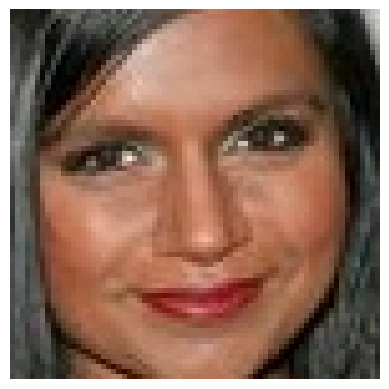

1/1 [==============================] - 0s 21ms/step
Predictions for Age Model:
1-8: 5.42%
9-19: 11.38%
20-31: 29.16%
32-60: 40.50%
61-110: 13.54%

Predictions for Gender Model:
male: 3.35%
female: 96.98%

Predictions for Emotions Model:
happy: 46.54%
anger: 50.56%
contempt: 57.47%
disgust: 47.78%
fear: 50.99%
sadness: 52.49%
surprise: 48.24%



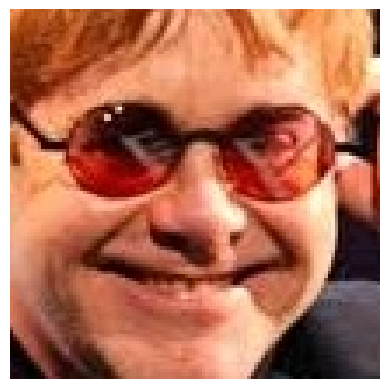

1/1 [==============================] - 0s 21ms/step
Predictions for Age Model:
1-8: 5.39%
9-19: 11.35%
20-31: 29.28%
32-60: 40.63%
61-110: 13.35%

Predictions for Gender Model:
male: 95.25%
female: 3.16%

Predictions for Emotions Model:
happy: 46.53%
anger: 50.60%
contempt: 57.19%
disgust: 47.79%
fear: 50.87%
sadness: 52.56%
surprise: 48.22%



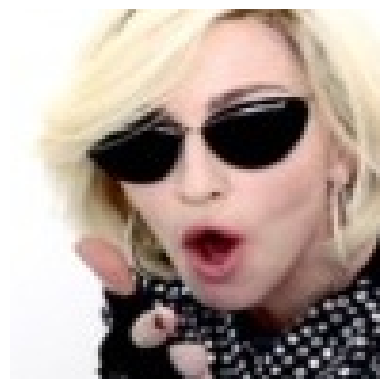

1/1 [==============================] - 0s 26ms/step
Predictions for Age Model:
1-8: 6.22%
9-19: 11.98%
20-31: 29.30%
32-60: 39.79%
61-110: 12.71%

Predictions for Gender Model:
male: 32.60%
female: 60.73%

Predictions for Emotions Model:
happy: 45.93%
anger: 51.50%
contempt: 57.29%
disgust: 47.68%
fear: 50.65%
sadness: 52.76%
surprise: 48.12%



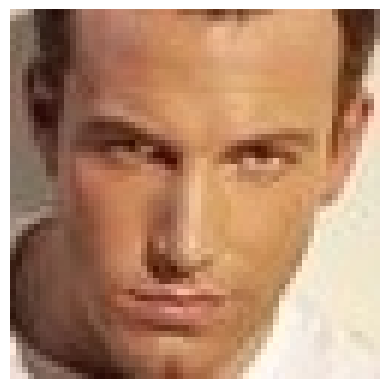

1/1 [==============================] - 0s 24ms/step
Predictions for Age Model:
1-8: 5.59%
9-19: 11.61%
20-31: 29.19%
32-60: 40.44%
61-110: 13.16%

Predictions for Gender Model:
male: 74.27%
female: 27.93%

Predictions for Emotions Model:
happy: 46.55%
anger: 50.65%
contempt: 57.61%
disgust: 47.95%
fear: 50.81%
sadness: 52.40%
surprise: 48.48%



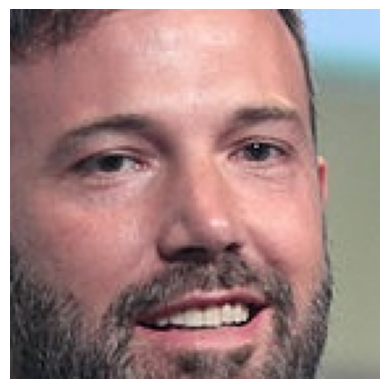

1/1 [==============================] - 0s 21ms/step
Predictions for Age Model:
1-8: 5.62%
9-19: 11.60%
20-31: 29.30%
32-60: 40.37%
61-110: 13.11%

Predictions for Gender Model:
male: 98.91%
female: 0.84%

Predictions for Emotions Model:
happy: 46.34%
anger: 50.80%
contempt: 57.67%
disgust: 47.82%
fear: 50.85%
sadness: 52.61%
surprise: 48.37%



In [ ]:
prepare_and_predict_random_faces(cropped_faces_folder, age_model, gender_model, emotion_model)